*Might be interesting:* Short [article](http://scienceblogs.com/cognitivedaily/2007/03/29/most-researchers-dont-understa/) on error bars and significance

# Instructions
1. To run notebook, go to the `Cell` menu above and click `Run All`. 
2. To hide all the code, just click the `Results Only` button above.
3. If something goes really wrong, then go to the `Kernel` menu above and click `Restart` and repeat Step 1.

You can interact with the plot below to select which combination of groups and dates you want to show.
You can CTRL+Click to select multiple items in the menus below.  

In [53]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn.apionly as sns
import numpy as np
import pandas as pd
import IPython.html.widgets as widgets
import os

from ggplot import *

from IPython.html.widgets import \
    interact,\
    interactive,\
    fixed

from IPython.display import \
    display,\
    clear_output

from pandas.tools.plotting import \
    scatter_matrix

from pandas import \
    DataFrame as df

from view import \
    plot_plates,\
    matrix_tree
    
from toolz import \
    pipe,\
    thread_first
    
from utils import \
    normalize_columns,\
    filter_and_drop,\
    filter_rows,\
    snd,\
    add_col,\
    get_files,\
    gen_filenames,\
    maybe_get_model,\
    persist_widget_value,\
    concatenate,\
    are_all_in

In [54]:
matplotlib.style.use('ggplot')

In [55]:
path = '/notebooks/Seahorse2/'
files = filter(lambda x: not x.startswith('.'), os.listdir(path))

In [56]:
data_files = filter(lambda f: 'crunched' in f,files)
# norm_files = filter(lambda f: 'Norm' in f,files)

In [57]:
def rename_measurement_col(name):
    if 'Measure' in name:
        return name.split()[0]
    else: 
        return name
    
# String -> DataFrame
def get_data(filename,date):
    return thread_first(
        filename,
        lambda filename: pd.read_csv(filename,skiprows=6),
        lambda d: d.rename(columns=rename_measurement_col),
        lambda d: d.rename(columns = {'Group':'GroupName'}),
        lambda d: add_col(d,'Date',date))    

In [58]:
raw_data = pd.concat(
    [get_data(os.path.join(path,filename),filename.split()[0])
        for filename in data_files]).dropna(how='all',axis=1)
data = raw_data

In [84]:
def plot_results(data, groups, dates, show_errorbars, show_error_fill, show_median, error_measure, parameter):
    
    groups = list(groups)
    dates = list(dates)
    
    new_data = data.copy()
    filtered_groups = new_data[new_data['GroupName'].isin(groups)]
    filtered_dates = filtered_groups[filtered_groups['Date'].isin(dates)]
    
    groupbys = filtered_dates.groupby(['Measurement','GroupName'])
    means = groupbys.mean()[[parameter]].unstack()[parameter]
    medians = groupbys.median()[[parameter]].unstack()[parameter]
    stds =  groupbys.std()[[parameter]].unstack()[parameter]
    sems =  groupbys.sem()[[parameter]].unstack()[parameter]
    
    # fill, errorbars, error measure
    
    if error_measure == 'SEM':
        errs = sems
    else: 
        errs = stds
    
    if show_median:
        medians.plot(kind='line', linewidth = 2)
    
    else:
        if show_errorbars:
            means.plot(kind='line', yerr = errs, linewidth = 2, capsize=3, capthick = 4, fmt = '-o')
        else:
            means.plot(kind='line', linewidth = 2)
    
    if show_error_fill:
        for group in filtered_dates['GroupName'].unique().tolist():
            plt.fill_between(means.index, means[group] - errs[group], means[group] + errs[group], alpha=0.3)
     
    fig = plt.gcf()
    fig.set_size_inches(17,8)
    plt.ylabel(parameter)
    plt.title("{} {}".format(
        parameter,
        ', Dates {}'.format(', '.join(dates)),
        ' (errorbars = {})'.format(error_measure) if show_errorbars or show_error_fill else ''))
    plt.ylim([-0.1,0.9])

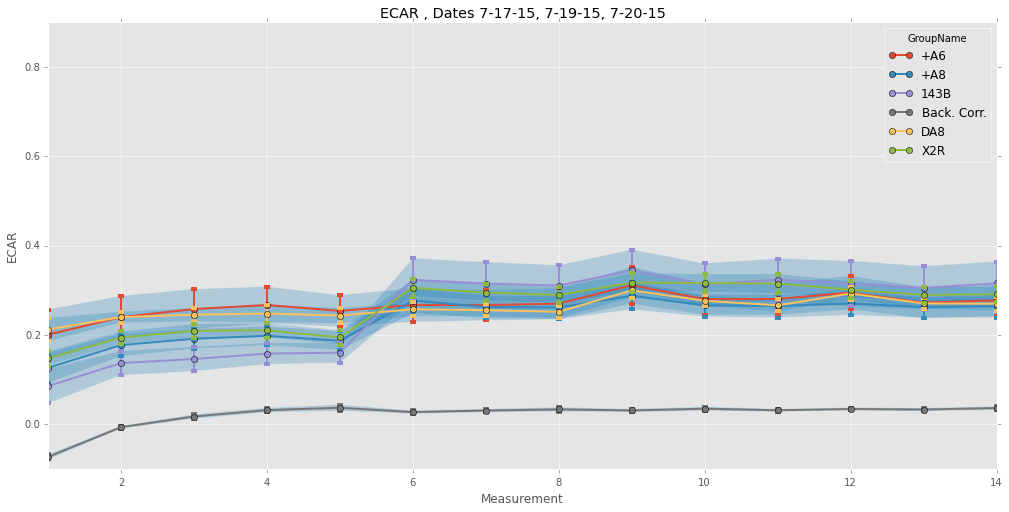

In [86]:
group_options = data['GroupName'].unique().tolist()
date_options = sorted(data['Date'].unique().tolist())

interact(
    plot_results,
    data = fixed(data),
    groups = widgets.SelectMultiple(
        options = group_options,
        value = group_options),
    dates = widgets.SelectMultiple(
        options = date_options,
        value = date_options),
    show_errorbars = True, 
    show_error_fill = True,
    show_median = False,
    error_measure = widgets.ToggleButtons(
        options = ['SEM','STD'],
        value = 'SEM'),
    parameter = widgets.ToggleButtons(
        options = ['OCR','ECAR'],
        value = 'OCR'));

# Show individual points

In [61]:
def plot_points(data, groups, dates, parameter):
    np.random.seed(10030423)
    groups = list(groups)
    dates = list(dates)
    
    new_data = data.copy()
    filtered_groups = new_data[new_data['GroupName'].isin(groups)]
    filtered_dates = filtered_groups[filtered_groups['Date'].isin(dates)]
    
    if not groups |are_all_in| filtered_dates['GroupName'].unique().tolist():
        missing_groups = list(set(groups).difference(set(filtered_dates['GroupName'].unique().tolist())))
        print "It looks like there might not be data for these groups for the day(s) you've chosen: {} .".format(' '.join(missing_groups))
        return
    jittered_data = filtered_dates[filtered_dates['GroupName'].isin(groups)].copy()
    jitter_strength = 0.4
    jittered_data['Measurement'] = jittered_data['Measurement'].map(lambda x: x + np.random.random() * jitter_strength)
    
    display(ggplot(aes(x = 'Measurement',y = parameter, color = 'GroupName'), data = jittered_data.reset_index(drop=True)) + geom_point());

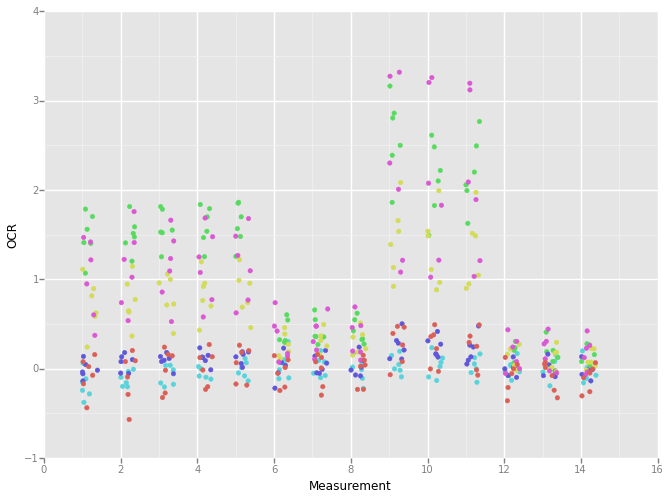

<ggplot: (8792167018025)>

In [62]:
interact(
    plot_points,
    data = fixed(data),
    groups = widgets.SelectMultiple(
        options = group_options,
        value = group_options),
    dates = widgets.SelectMultiple(
        options = date_options,
        value = date_options),
    parameter = widgets.ToggleButtons(
        options = ['OCR','ECAR'],
        value = 'OCR'));